## This script calculates the cosine similarity between a reference text and texts in Class0 and texts in Class1. <br> Class1 texts are related to the reference text, Class0 texts are not.

In [94]:
import os
base = '/Users/Viktoria/Desktop/NLP_DocEmbeddings'
docs = os.path.join(base, 'Documents')
raw = os.path.join(base, 'Raw_data')
viz = os.path.join(base, 'Data_visualisation')
os.chdir(base)

In [52]:
import pandas as pd
import numpy as np
import re
import time
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import docx2txt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from read_file import read_file
from clean_text import lemmatize
from clean_text import clean_text

pd.options.display.max_rows = 8000

In [3]:
#pip install -r requirements.txt

In [4]:
#pip install sentence-transformers

In [5]:
#pip install git+https://github.com/jbarlow83/OCRmyPDF.git

## Step 1. Access the documents

In [6]:
#Get the texts

class1 = [doc for doc in os.listdir(os.path.join(base, 'Raw_data/Class1'))]
class0 = [doc for doc in os.listdir(os.path.join(base, 'Raw_data/Class0'))]

print('Relevant documents: ', len(class1), '\nIrrelevant documents: ', len(class0))

Relevant documents:  22 
Irrelevant documents:  20


In [7]:
df = pd.DataFrame(columns=['Document', 'Class', 'Directory'])

row=0
for doc in class1:
    df.loc[row, 'Document'] = doc
    df.loc[row, 'Class'] = 1
    df.loc[row, 'Directory'] = os.path.join(base, 'Raw_data/Class1')
    row=row+1
    
for doc in class0:
    df.loc[row, 'Document'] = doc
    df.loc[row, 'Class'] = 0
    df.loc[row, 'Directory'] = os.path.join(base, 'Raw_data/Class0')
    row=row+1

In [8]:
#loop through them all at once. 

tqdm.pandas()

start = time.time()

df['Text'] = df.progress_apply(lambda x: read_file(x['Document'], x['Directory']), axis=1)

end = time.time()
print(end - start)

 90%|█████████ | 38/42 [02:30<00:11,  2.85s/it]

psr_mr18_1_3_pass-through_analysis_consultation_february_2019.pdf


100%|██████████| 42/42 [02:42<00:00,  3.87s/it]

162.3767900466919


## Step 2. Text cleaning and lemmatization

In [9]:
#A set of words we want to screen out as corpus-specific stop words, i.e. 'article', 'paragraph', etc

os.chdir(os.path.join(base, 'Documents'))

useless = docx2txt.process("useless_words.docx")
useless = re.findall(r'\w+', useless)
useless = lemmatize(useless)
useless = [u.lower() for u in useless]

In [11]:
# All non-English words will be disposed of. Keep important non-English words on this list.

informative = docx2txt.process("informative_words.docx")
informative = re.findall(r'\w+', informative)
informative = [i.lower() for i in informative]

In [14]:
#loop through them all at once.

df['Cleaned_Text'] = df['Text'].progress_apply(clean_text, args=(useless,informative))

100%|██████████| 42/42 [00:59<00:00,  1.43s/it]


In [20]:
df = df.dropna()

## Step 4. Import and clean the reference text

In [40]:
#import keywords
os.chdir(raw)

with open('Reftext.txt', 'r+') as f:
    reftext = f.readlines()  
    
reftext = [re.sub('\n', '', r) for r in reftext]
reftext = [re.sub(r'[^a-zA-Z ]', '', r) for r in reftext]
reftext = list(filter(None, reftext))
reftext = ' '.join([r for r in reftext])

In [41]:
reftext = clean_text(reftext, useless, informative)
reftext = ' '.join([r for r in reftext])

## Step 5. Get word embeddings for the reftext and the documents. <br> Calculate a similarity score and add it as a column.

In [77]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

#join the cleaned text together into a string
df['Join_Text'] = [' '.join(text) for text in df.Cleaned_Text]

all_embeddings = []

for r,v in df.iterrows():
    
    text = df.loc[r, 'Join_Text']
    doc_embedding = model.encode([text])
    all_embeddings.extend(doc_embedding)
    sim = cosine_similarity(doc_embedding, model.encode([reftext]))
    num = float(sim)
        
    df.loc[r, 'Reference_Similarity'] = num

In [78]:
# Get the mean similarity in each class

sims = df.groupby('Class')['Reference_Similarity'].mean()

In [79]:
sims

Class
0    0.750874
1    0.766385
Name: Reference_Similarity, dtype: float64

## Step 6. Plot the means and SDs

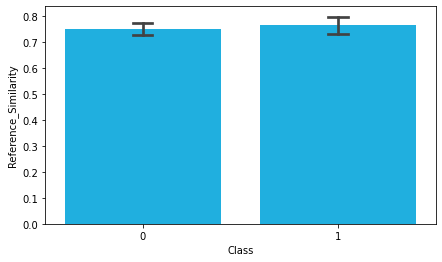

In [80]:
plt.figure(figsize=(7, 4))

ax = sns.barplot(x='Class', y='Reference_Similarity', data=df, estimator=np.mean, ci=95, capsize=0.1, color='deepskyblue')

## Step 7. Visualise document embeddings

In [81]:
indexes = df.Document

In [82]:
all_embeddings[0].shape

(768,)

In [83]:
embeds = pd.DataFrame(data=all_embeddings, index=indexes)

In [84]:
embeds.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
Document,,,,,,,,,,,,,,,,,,,,,
MT FIAU implementing procedures Application of AML CTF obligations to the virtual financial assets sector.pdf,-0.805823,-0.197887,-0.103661,-0.120870,-0.174182,-0.267405,0.351279,-0.327458,-0.151043,0.484858,...,-1.131412,-0.169716,0.576606,0.579641,0.168141,0.198241,-0.773821,-0.059091,0.304091,-0.238853
MGA-VFA-and-ITA-sandbox-v.3-Final-2.pdf,-0.777515,0.177517,0.721073,-0.995933,-0.038598,-0.534895,0.259265,-0.068081,0.190695,-0.343231,...,-0.955157,-0.595964,0.047654,0.829680,0.216112,-0.008417,-0.047991,0.472545,0.090047,-0.449344
IPOL_STU(2018)604970_EN.pdf,-0.707766,-0.108831,-0.051706,-0.479855,-0.515779,-0.591586,0.515886,-0.215531,0.228115,-0.130907,...,-0.602369,-0.236422,0.017709,1.114011,-0.178531,0.071325,-0.139074,-0.148846,0.327224,-0.155897
Philippines VASP guidelines.pdf,-1.243931,-0.385060,0.501914,-0.399655,-0.261370,-0.619135,-0.216848,-0.051782,0.142936,-0.883885,...,-0.688449,-0.773566,0.494649,0.414052,-0.043302,0.429505,-0.150053,0.400978,0.036838,-0.373832
MT Virtual Financial Assets Act.pdf,-1.160633,-0.428397,0.156079,-0.540268,-0.141783,-0.941596,0.606129,0.339077,-0.908347,-0.544339,...,-0.739182,-0.458631,0.919171,0.447259,-0.258057,0.007148,-0.453211,0.023486,0.357389,0.063188


In [85]:
#PCA for dimensionality reduction

#Computing the correlation matrix
X_corr=embeds.corr()

#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(X_corr)

#Sorting the eigen vectors coresponding to eigen values in descending order
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

#Taking first 2 components which explain maximum variance for projecting
new_vectors=vectors[:,:2]

#Projecting it onto new dimesion with 2 axis
neww_X=np.dot(embeds,new_vectors)

In [86]:
neww_X

array([[ 0.53955228+0.j,  2.72597434+0.j],
       [ 0.45856716+0.j, -0.23051911+0.j],
       [ 1.17830852+0.j,  1.10723566+0.j],
       [ 2.0028853 +0.j, -3.52361846+0.j],
       [-5.25874485+0.j,  0.69534413+0.j],
       [-2.00403729+0.j,  0.33689798+0.j],
       [-2.42499321+0.j, -1.91260273+0.j],
       [-4.89799929+0.j,  0.3477551 +0.j],
       [-2.72764469+0.j, -1.22699883+0.j],
       [-2.57852235+0.j,  2.51655129+0.j],
       [ 1.50714079+0.j, -2.19972396+0.j],
       [-0.02361399+0.j,  3.06935385+0.j],
       [-2.62436056+0.j, -0.64576261+0.j],
       [ 1.3996239 +0.j,  0.91536264+0.j],
       [ 1.32689256+0.j,  0.59366931+0.j],
       [ 1.67426787+0.j, -0.38929698+0.j],
       [-4.80922777+0.j,  0.14456788+0.j],
       [-2.61871587+0.j, -1.01083051+0.j],
       [-6.86496496+0.j, -2.87882978+0.j],
       [-2.76768888+0.j, -0.63242293+0.j],
       [-2.6137632 +0.j, -1.52772034+0.j],
       [-5.38198833+0.j, -2.61192079+0.j],
       [-0.87235746+0.j, -0.1045212 +0.j],
       [-0.

/Users/Viktoria/anaconda3/envs/Flawless/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


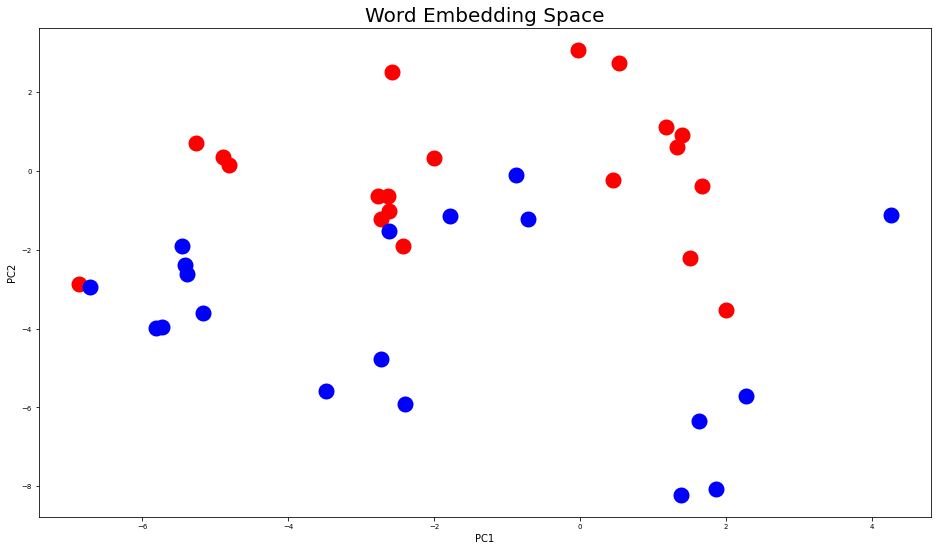

In [99]:
import matplotlib.pyplot as plt

docs1 = df[df.Class==1].Document.tolist()
docs0 = df[df.Class==0].Document.tolist()

plt.figure(figsize=(16,9))
plt.xlabel("PC1",size=10)
plt.ylabel("PC2",size=10)
plt.rcParams.update({'font.size': 7})
plt.title("Word Embedding Space",size=20)

docs=list(embeds.index)
for i, doc in enumerate(docs):
    if doc in docs1:
        plt.scatter(neww_X[i,0],neww_X[i,1],linewidths=10,color='red')
    elif doc in docs0:
        plt.scatter(neww_X[i,0],neww_X[i,1],linewidths=10,color='blue')
        
os.chdir(viz)
plt.savefig('Topic embedding space.pdf')